In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import pylab as pl
import matplotlib.pyplot as plt
from scipy import optimize
import time

%matplotlib inline

In [4]:
df = pd.read_csv("../cs-training.csv")
features  =  ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'age', 'NumberOfTimes90DaysLate']
X=df[features]
Y=df.SeriousDlqin2yrs
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [7]:
# Random Logits
num_logits = 20
num_features = 2
clf = BaggingClassifier(base_estimator = LogisticRegression(),n_estimators=num_logits, max_features = num_features)
clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=2,
         max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [10]:
# print feature importances and feature indices

for logit in clf.estimators_:
    print (logit.coef_)
    
for logit in clf.estimators_features_:
    print (logit)

[[  3.67392304e-02  -6.00057139e-05]]
[[ -2.71463340e-05  -3.25516633e-02]]
[[  3.76742457e-02   2.09254821e-05]]
[[ 0.03318251 -0.03285496]]
[[-0.00032668 -0.00037608]]
[[ -3.93412229e-05   3.52470551e-02]]
[[ -3.36315576e-02  -7.60181556e-05]]
[[ -1.56297515e-04  -6.79989991e-05]]
[[ -3.24344484e-02  -4.83127029e-05]]
[[-0.03254642  0.03120367]]
[[ -3.35089388e-02  -2.85220629e-05]]
[[-0.03381188 -0.00015845]]
[[  3.75992334e-02  -3.93560243e-05]]
[[ -2.06564950e-05  -3.34082316e-02]]
[[-0.00010517 -0.03292757]]
[[ -6.13492399e-05  -8.40369572e-05]]
[[ -3.70296565e-05   3.64398812e-02]]
[[-0.00018111 -0.03421633]]
[[  3.56529546e-02  -5.05495706e-05]]
[[  3.89288876e-02  -6.32205577e-05]]
[3 0]
[1 2]
[3 0]
[3 2]
[0 1]
[1 3]
[2 0]
[0 1]
[2 0]
[2 3]
[2 1]
[2 0]
[3 1]
[1 2]
[0 2]
[1 0]
[1 3]
[0 2]
[3 1]
[3 0]


In [24]:
total_features = len(features)
feature_importance_matrix = np.zeros((num_logits, total_features))
row = 0
for feature in clf.estimators_features_:
    for i in range(num_features):
        feature_importance_matrix[row][feature[i]] = clf.estimators_[row].coef_[0][i] 
    row += 1
feature_importance_matrix[feature_importance_matrix==0]=['nan']
#print feature_importance_matrix
mean_importance_rl = np.nanmean(feature_importance_matrix, dtype=np.float64, axis=0)
std_importance_rl = np.nanstd(feature_importance_matrix, dtype=np.float64,axis=0)

#print "mean is ", np.nanmean(feature_importance_matrix, dtype=np.float64, axis=0)
#print "stdev is ", np.nanstd(feature_importance_matrix, dtype=np.float64,axis=0)


[[ -6.00057139e-05              nan              nan   3.67392304e-02]
 [             nan  -2.71463340e-05  -3.25516633e-02              nan]
 [  2.09254821e-05              nan              nan   3.76742457e-02]
 [             nan              nan  -3.28549562e-02   3.31825087e-02]
 [ -3.26677735e-04  -3.76084334e-04              nan              nan]
 [             nan  -3.93412229e-05              nan   3.52470551e-02]
 [ -7.60181556e-05              nan  -3.36315576e-02              nan]
 [ -1.56297515e-04  -6.79989991e-05              nan              nan]
 [ -4.83127029e-05              nan  -3.24344484e-02              nan]
 [             nan              nan  -3.25464243e-02   3.12036699e-02]
 [             nan  -2.85220629e-05  -3.35089388e-02              nan]
 [ -1.58446999e-04              nan  -3.38118810e-02              nan]
 [             nan  -3.93560243e-05              nan   3.75992334e-02]
 [             nan  -2.06564950e-05  -3.34082316e-02              nan]
 [ -1.

In [12]:
# let's compare it to RFs

clfrf = RandomForestClassifier(n_estimators= num_logits, max_features = num_features, n_jobs=-1)
clfrf.fit(X_train, y_train)
clfrf.feature_importances_

array([ 0.35072607,  0.38832715,  0.14217785,  0.11876893])

In [27]:
def plot_feature_importance(mean_importance_array, std_importance_array, indices, label):
    # Print the feature ranking
    print("Ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], mean_importance_array[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title(label)
    plt.bar(range(X.shape[1]), mean_importance_array[indices],
            color="r", yerr=std_importance_array[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

Ranking:
1. feature 3 (0.035852)
2. feature 2 (-0.033189)
3. feature 0 (-0.000113)
4. feature 1 (-0.000075)


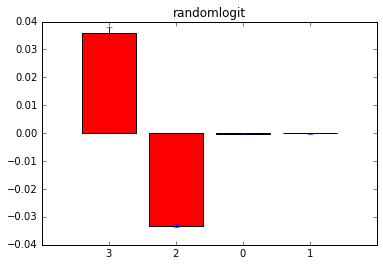

Ranking:
1. feature 1 (0.388327)
2. feature 0 (0.350726)
3. feature 2 (0.142178)
4. feature 3 (0.118769)


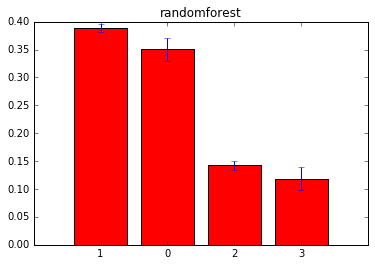

In [28]:
indices_rl = np.argsort(np.abs(mean_importance_rl))[::-1]
# std_important_rl is buggy but will fix it later
plot_feature_importance(mean_importance_rl, std_importance_rl, indices_rl, "randomlogit")

importance_rf = clfrf.feature_importances_
std_importance_rf = np.std([tree.feature_importances_ for tree in clfrf.estimators_],
             axis=0)
indices_rf = np.argsort(importance_rf)[::-1]
plot_feature_importance(importance_rf, std_importance_rf, indices_rf, "randomforest")
